# Trabalho de Séries Temporais (A2)

**Grupo:**
- Amanda Perez
- Eduardo Adame
- Juan Belieni
- Kayo Yokoyama
- Lucas Westfal

Para este trabalho, foram testados os seguintes modelos:
| Modelo |  Val MSE | Test MAE | Epochs |
| --- | --- | --- | --- |
| Feedforward | 9.52 | 2.57 | 25 |
| 1D CNN | 9.36 | 2.57 | 18 |
| RNN with LSTM | 9.11 | 2.56 | 46 |
| RNN with LSTM cell and recurrent dropout | 9.12 | 2.51 | 34 |
| RNN with GRU | 9.09 | 2.51 | 41 |
| RNN with GRU cell and recurrent dropout | 9.54 | 2.51 | 37
| Stacked RNN layers | 9.56 | 2.56 | 37 |
| Stacked RNN using GRU | 9.09 | 2.51 | 41 |
| Transformer | 9.46 | 2. 51 | 21 |

## References

* Deep Learning with python, second edition. Chapter 10.

## Install libraries

In [ ]:
!pip3 install -q tensorflow keras

## Import Libraries


In [1]:
import os
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2023-12-05 19:12:17.347653: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 19:12:17.368268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 19:12:17.368284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 19:12:17.368865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 19:12:17.372459: I tensorflow/core/platform/cpu_feature_guar

## Data

### Download

In [2]:
!rm jena_climate_2009_2016.*
!rm -r __MACOSX
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-12-05 19:12:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolvendo s3.amazonaws.com (s3.amazonaws.com)... 16.182.42.152, 52.217.203.88, 54.231.230.176, ...
Conectando-se a s3.amazonaws.com (s3.amazonaws.com)|16.182.42.152|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 13565642 (13M) [application/zip]
Salvando em: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12,94M  8,46MB/s    em 1,5s    

2023-12-05 19:12:25 (8,46 MB/s) - ‘jena_climate_2009_2016.csv.zip’ salvo [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
tf.config.list_physical_devices('GPU')

2023-12-05 19:12:31.841263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-12-05 19:12:31.868968: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 19:12:31.869068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
device_name = tf.test.gpu_device_name()

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-12-05 19:12:34.732846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 19:12:34.733303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 19:12:34.733552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Load

Load data:

In [5]:
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [6]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

### Plot the data

Plot the temperature over time:

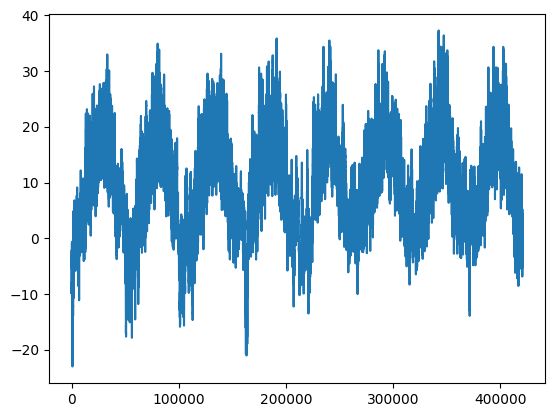

In [7]:
plt.plot(range(len(temperature)), temperature)

First 10 days of temperature data. 24 * 6 = 144 data points per day.

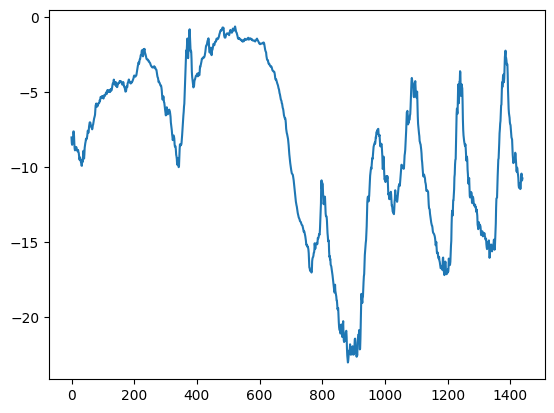

In [8]:
plt.plot(range(1440), temperature[:1440])

## Task



```
# Isto está formatado como código
```

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

This notebook contains sample code for:

* Feedforward neural network
* 1D convolution neural network
* 3 variations of recurring neural network

Optimize the three classes of models above to give the best MAE. In addtion, use a transformer to compete in terms of MAE.

This [page](https://keras.io/examples/timeseries/timeseries_classification_transformer/) contains a reference of using a Transformer for time-series data.

The sample code below is a starting point. Your job is to extract the most value out of the models mentioned above. You are free to go beyond what is requested here and try out different models if you like.

Return a `.ipynb` containing the code (one section per model) and start the document with a summary of the models you tried and their respective MAEs in a table.

**Deadline**: 05/12

### Prepare the data

Decide the number of data points that will be assigned to training, validation and test sets.

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalize the data.

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Create `tensorflow.data.Dataset` for training, validation and test splits:

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 512

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

2023-12-05 19:12:54.258093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 19:12:54.258522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 19:12:54.258753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Check the input dimensions:

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (512, 120, 14)
targets shape: (512,)


Use naive model as baseline:

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Feedforward neural network

In [15]:
def create_ff_model(dropout=1/3):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    x = layers.Concatenate()([inputs[:, 0:-2, :], inputs[:, 1:-1, :], inputs[:, 2:, :]])
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)

    temps = inputs[:, :, 1] * std[1] + mean[1]
    temps = layers.Reshape(temps.shape[1:] + (1,))(temps)

    naive_est = temps[:, -1, :]

    mean_est = inputs[:, :, :] * std[1] + mean[1]
    mean_est = layers.GlobalAveragePooling1D()(mean_est)
    mean_est = layers.Flatten()(mean_est)

    x = layers.Concatenate()([x, naive_est, mean_est])
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Concatenate()([x, naive_est, mean_est])
    x = layers.Dense(1)(x)

    outputs = x

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

ff_model = create_ff_model()
ff_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 14)]            0         []                            
                                                                                                  
 tf.__operators__.getitem_6  (None, 118, 14)              0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_7  (None, 118, 14)              0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                            

In [16]:
ff_model.compile(optimizer='adam', loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ff_model.keras', monitor='val_loss', save_best_only=True)

with tf.device("GPU:0"):
    ff_history = ff_model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        callbacks=[early_stopping, model_checkpoint],
    )

ff_model.save('./models/ff_model.h5')

print(f"Test MAE: {ff_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100


2023-12-05 15:26:56.639650: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd53969b600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 15:26:56.639667: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-05 15:26:56.646110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 15:26:57.356618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1701800817.409942    7876 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


410/410 [==============================] - 6s 9ms/step - loss: 54.9775 - mae: 5.4003 - val_loss: 10.8534 - val_mae: 2.5630
Epoch 2/100
410/410 [==============================] - 4s 9ms/step - loss: 14.4574 - mae: 2.9918 - val_loss: 9.9651 - val_mae: 2.4594
Epoch 3/100
410/410 [==============================] - 4s 9ms/step - loss: 12.2108 - mae: 2.7540 - val_loss: 9.8083 - val_mae: 2.4450
Epoch 4/100
410/410 [==============================] - 4s 9ms/step - loss: 11.8421 - mae: 2.7120 - val_loss: 9.6843 - val_mae: 2.4304
Epoch 5/100
410/410 [==============================] - 4s 9ms/step - loss: 11.6338 - mae: 2.6858 - val_loss: 9.5722 - val_mae: 2.4144
Epoch 6/100
410/410 [==============================] - 4s 9ms/step - loss: 11.4898 - mae: 2.6661 - val_loss: 9.5247 - val_mae: 2.4090
Epoch 7/100
410/410 [==============================] - 4s 9ms/step - loss: 11.3630 - mae: 2.6501 - val_loss: 9.5020 - val_mae: 2.4064
Epoch 8/100
410/410 [==============================] - 4s 9ms/step - loss

/home/alunos/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 1s 6ms/step - loss: 10.7972 - mae: 2.5718
Test MAE: 2.57


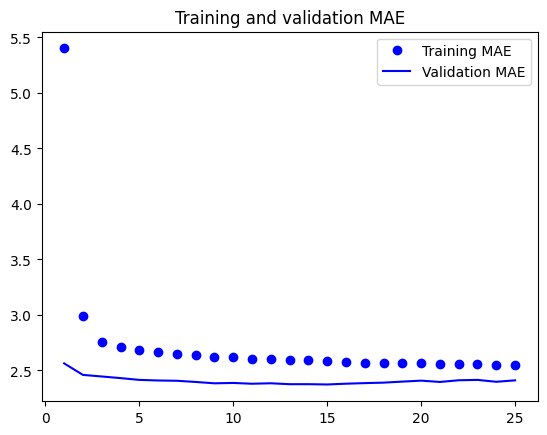

In [17]:
loss = ff_history.history["mae"]
val_loss = ff_history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [18]:
# ff_model.layers[-1].get_weights()

In [20]:
# new_model = tf.keras.models.load_model('./models/conv_model.h5')
# new_model.evaluate(test_dataset)[1]

  1/203 [..............................] - ETA: 3:13 - loss: 10.0910 - mae: 2.4898

2023-12-05 15:41:59.549431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-05 15:41:59.671306: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


203/203 [==============================] - 2s 6ms/step - loss: 10.7447 - mae: 2.5642


2.5642166137695312

## 1D convolution neural network

In [21]:
def create_conv_model():
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    # Concatenate three consecutive time steps to capture temporal dependencies
  #  x = layers.Concatenate()([inputs[:, 0:-2, :], inputs[:, 1:-1, :], inputs[:, 2:, :]])

    # Apply seasonality estimation
    seasonality_branch = layers.Conv1D(8, 6, activation="relu")(inputs)
    seasonality_branch = layers.MaxPooling1D(2)(seasonality_branch)
    seasonality_branch = layers.GlobalAveragePooling1D()(seasonality_branch)

    # Naive Estimation
    temps = inputs[:, :, 1] * std[1] + mean[1]
    temps = layers.Reshape(temps.shape[1:] + (1,))(temps)
    naive_est = temps[:, -1, :]

    # Apply mean estimation
    mean_est = inputs[:, :, 1] * std[1] + mean[1]
    mean_est = layers.Reshape(mean_est.shape[1:] + (1,))(mean_est)
    mean_est = layers.GlobalAveragePooling1D()(mean_est)
    mean_est = layers.Flatten()(mean_est)

    x = layers.Concatenate()([seasonality_branch, naive_est, mean_est])

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    return model

conv_model = create_conv_model()

conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 14)]            0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 120)                  0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem (  (None, 120)                  0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                              

In [22]:
conv_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

conv_history = conv_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)

conv_model.save('./models/conv_model.h5')

print(f"Test MAE: {conv_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50


2023-12-05 15:42:17.198062: I external/local_xla/xla/service/service.cc:168] XLA service 0x55f8779e95c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 15:42:17.198079: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-05 15:42:17.204545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701801737.251040    6944 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


410/410 [==============================] - 5s 9ms/step - loss: 17.2893 - mae: 3.2344 - val_loss: 10.0413 - val_mae: 2.4977
Epoch 2/50
410/410 [==============================] - 4s 9ms/step - loss: 11.0165 - mae: 2.6135 - val_loss: 9.4228 - val_mae: 2.3986
Epoch 3/50
410/410 [==============================] - 4s 9ms/step - loss: 10.8688 - mae: 2.5853 - val_loss: 9.3513 - val_mae: 2.3867
Epoch 4/50
410/410 [==============================] - 4s 9ms/step - loss: 10.8199 - mae: 2.5781 - val_loss: 9.3368 - val_mae: 2.3845
Epoch 5/50
410/410 [==============================] - 4s 9ms/step - loss: 10.7739 - mae: 2.5722 - val_loss: 9.3385 - val_mae: 2.3843
Epoch 6/50
410/410 [==============================] - 4s 9ms/step - loss: 10.7353 - mae: 2.5673 - val_loss: 9.4041 - val_mae: 2.3903
Epoch 7/50
410/410 [==============================] - 4s 9ms/step - loss: 10.7015 - mae: 2.5629 - val_loss: 9.4896 - val_mae: 2.4006
Epoch 8/50
410/410 [==============================] - 4s 9ms/step - loss: 10.66

/home/alunos/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 1s 5ms/step - loss: 10.7444 - mae: 2.5710
Test MAE: 2.57


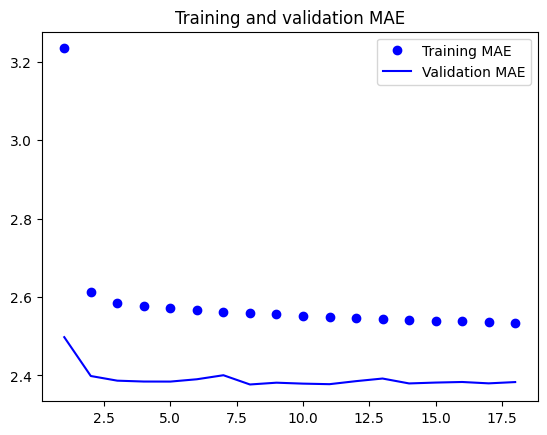

In [23]:
loss = conv_history.history["mae"]
val_loss = conv_history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with LSTM cell

In [27]:
import keras
from keras import layers

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8)(inputs)
outputs = layers.Dense(1)(x)
lstm_model = keras.Model(inputs, outputs)

In [25]:
lstm_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 736       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks = [early_stopping],
)

# lstm_model.save('./models/lstm_model.h5')

print(f"Test MAE: {lstm_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
410/410 [==============================] - 5s 10ms/step - loss: 94.8577 - mae: 7.7310 - val_loss: 63.2804 - val_mae: 6.1318
Epoch 2/50
410/410 [==============================] - 4s 9ms/step - loss: 49.9718 - mae: 5.3541 - val_loss: 38.8608 - val_mae: 4.6573
Epoch 3/50
410/410 [==============================] - 4s 9ms/step - loss: 32.6719 - mae: 4.2448 - val_loss: 26.2716 - val_mae: 3.7861
Epoch 4/50
410/410 [==============================] - 4s 9ms/step - loss: 23.2412 - mae: 3.5704 - val_loss: 19.5278 - val_mae: 3.2680
Epoch 5/50
410/410 [==============================] - 4s 9ms/step - loss: 18.0657 - mae: 3.1747 - val_loss: 15.6663 - val_mae: 2.9450
Epoch 6/50
410/410 [==============================] - 4s 9ms/step - loss: 15.1041 - mae: 2.9335 - val_loss: 13.3640 - val_mae: 2.7487
Epoch 7/50
410/410 [==============================] - 4s 9ms/step - loss: 13.3404 - mae: 2.7853 - val_loss: 12.0531 - val_mae: 2.6372
Epoch 8/50
410/410 [==============================] - 4s 9ms/

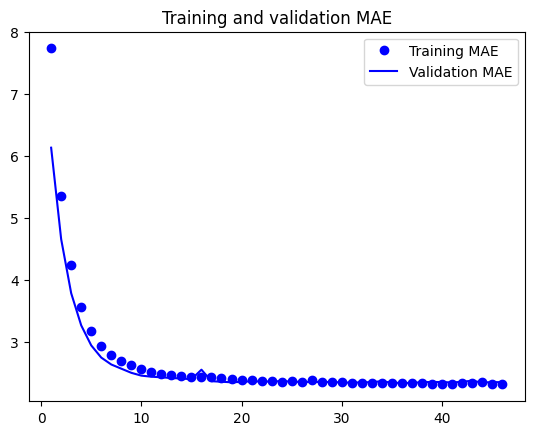

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [29]:
last_lstm_model = tf.keras.models.load_model('./models/lstm_model.h5')
last_lstm_model.evaluate(test_dataset)[1]

203/203 [==============================] - 2s 7ms/step - loss: 10.4181 - mae: 2.5325


2.532543659210205

## RNN with LSTM cell and recurrent dropout

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
lstm_dropout_model = keras.Model(inputs, outputs)
lstm_dropout_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                1984      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
lstm_dropout_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = lstm_dropout_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks = [early_stopping]
)

lstm_dropout_model.save('./models/lstm_dropout_model.h5')

print(f"Test MAE: {lstm_dropout_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
410/410 [==============================] - 33s 77ms/step - loss: 66.2089 - mae: 6.2585 - val_loss: 29.6353 - val_mae: 4.0446
Epoch 2/50
410/410 [==============================] - 32s 77ms/step - loss: 30.2499 - mae: 4.1483 - val_loss: 17.3045 - val_mae: 3.0906
Epoch 3/50
410/410 [==============================] - 32s 77ms/step - loss: 23.7785 - mae: 3.7129 - val_loss: 13.2777 - val_mae: 2.7404
Epoch 4/50
410/410 [==============================] - 32s 77ms/step - loss: 21.2378 - mae: 3.5276 - val_loss: 12.1349 - val_mae: 2.6466
Epoch 5/50
410/410 [==============================] - 32s 77ms/step - loss: 19.9204 - mae: 3.4209 - val_loss: 10.7062 - val_mae: 2.5046
Epoch 6/50
410/410 [==============================] - 32s 77ms/step - loss: 19.0793 - mae: 3.3449 - val_loss: 10.2271 - val_mae: 2.4615
Epoch 7/50
410/410 [==============================] - 32s 77ms/step - loss: 18.5916 - mae: 3.3038 - val_loss: 9.8072 - val_mae: 2.4207
Epoch 8/50
410/410 [=============================

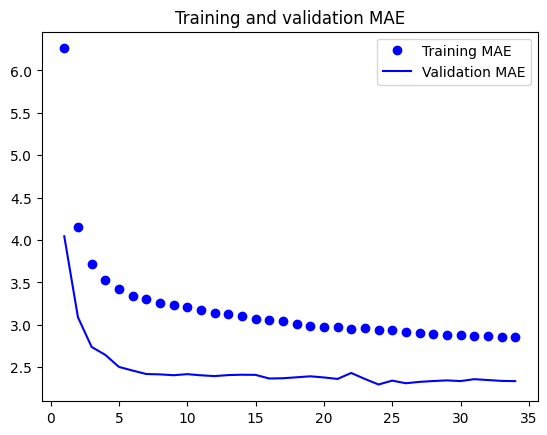

In [35]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with GRU cell:

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(8)(inputs)
outputs = layers.Dense(1)(x)
gru_model = keras.Model(inputs, outputs)
gru_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru_1 (GRU)                 (None, 8)                 576       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 585 (2.29 KB)
Trainable params: 585 (2.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
gru_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = gru_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks = [early_stopping]
)

gru_model.save('./models/gru_model.h5')

print(f"Test MAE: {gru_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
410/410 [==============================] - 5s 10ms/step - loss: 89.8596 - mae: 7.5907 - val_loss: 56.8969 - val_mae: 5.7918
Epoch 2/50
410/410 [==============================] - 4s 9ms/step - loss: 42.5229 - mae: 4.8688 - val_loss: 34.4081 - val_mae: 4.3357
Epoch 3/50
410/410 [==============================] - 4s 9ms/step - loss: 27.6776 - mae: 3.8800 - val_loss: 23.4802 - val_mae: 3.5291
Epoch 4/50
410/410 [==============================] - 4s 9ms/step - loss: 20.2359 - mae: 3.3326 - val_loss: 17.9929 - val_mae: 3.1050
Epoch 5/50
410/410 [==============================] - 4s 9ms/step - loss: 16.2595 - mae: 3.0206 - val_loss: 14.8557 - val_mae: 2.8460
Epoch 6/50
410/410 [==============================] - 4s 9ms/step - loss: 13.9495 - mae: 2.8317 - val_loss: 12.9219 - val_mae: 2.6839
Epoch 7/50
410/410 [==============================] - 4s 9ms/step - loss: 12.5031 - mae: 2.7088 - val_loss: 11.6949 - val_mae: 2.5772
Epoch 8/50
410/410 [==============================] - 4s 9ms/

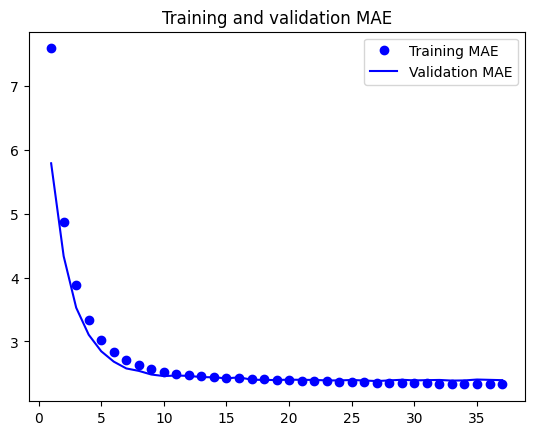

In [40]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with GRU cell and recurrent dropout:

In [41]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
gru_dropout_model = keras.Model(inputs, outputs)
gru_dropout_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
gru_dropout_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = gru_dropout_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks = [early_stopping]
)

gru_dropout_model.save('./models/gru_dropout_model.h5')

print(f"Test MAE: {gru_dropout_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
410/410 [==============================] - 33s 77ms/step - loss: 76.4170 - mae: 6.7682 - val_loss: 38.4760 - val_mae: 4.6554
Epoch 2/50
410/410 [==============================] - 31s 76ms/step - loss: 34.7686 - mae: 4.4185 - val_loss: 21.0968 - val_mae: 3.3881
Epoch 3/50
410/410 [==============================] - 32s 77ms/step - loss: 25.7277 - mae: 3.8266 - val_loss: 15.4688 - val_mae: 2.9321
Epoch 4/50
410/410 [==============================] - 31s 76ms/step - loss: 22.3229 - mae: 3.5915 - val_loss: 12.8084 - val_mae: 2.7005
Epoch 5/50
410/410 [==============================] - 32s 77ms/step - loss: 20.7097 - mae: 3.4726 - val_loss: 11.5757 - val_mae: 2.5977
Epoch 6/50
410/410 [==============================] - 32s 77ms/step - loss: 19.6202 - mae: 3.3845 - val_loss: 10.7424 - val_mae: 2.5190
Epoch 7/50
410/410 [==============================] - 32s 77ms/step - loss: 19.0040 - mae: 3.3335 - val_loss: 10.1233 - val_mae: 2.4577
Epoch 8/50
410/410 [============================

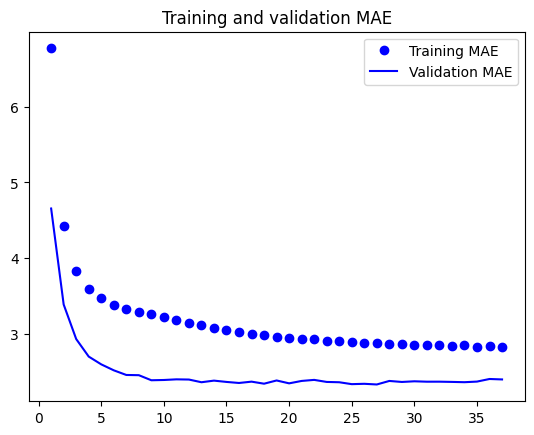

In [43]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked RNN layers

In [56]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
stacked_rnn2_model = keras.Model(inputs, outputs)

stacked_rnn2_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 lstm_12 (LSTM)              (None, 120, 8)            736       
                                                                 
 lstm_13 (LSTM)              (None, 8)                 544       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1289 (5.04 KB)
Trainable params: 1289 (5.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
stacked_rnn2_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = stacked_rnn2_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping],
)
print(f"Test MAE: {stacked_rnn2_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
410/410 [==============================] - 62s 147ms/step - loss: 89.5888 - mae: 7.4415 - val_loss: 54.7842 - val_mae: 5.6579
Epoch 2/50
410/410 [==============================] - 60s 147ms/step - loss: 50.5572 - mae: 5.3959 - val_loss: 34.5297 - val_mae: 4.3747
Epoch 3/50
410/410 [==============================] - 60s 146ms/step - loss: 38.5885 - mae: 4.6593 - val_loss: 24.2716 - val_mae: 3.6181
Epoch 4/50
410/410 [==============================] - 61s 148ms/step - loss: 32.3387 - mae: 4.2602 - val_loss: 18.8772 - val_mae: 3.1896
Epoch 5/50
410/410 [==============================] - 60s 146ms/step - loss: 28.9524 - mae: 4.0399 - val_loss: 15.8354 - val_mae: 2.9442
Epoch 6/50
410/410 [==============================] - 60s 146ms/step - loss: 26.9706 - mae: 3.9058 - val_loss: 14.1018 - val_mae: 2.8037
Epoch 7/50
410/410 [==============================] - 60s 146ms/step - loss: 25.3612 - mae: 3.7992 - val_loss: 12.9426 - val_mae: 2.7089
Epoch 8/50
410/410 [=====================

In [58]:
stacked_rnn2_model.save('./models/stacked_rnn2_model.h5')

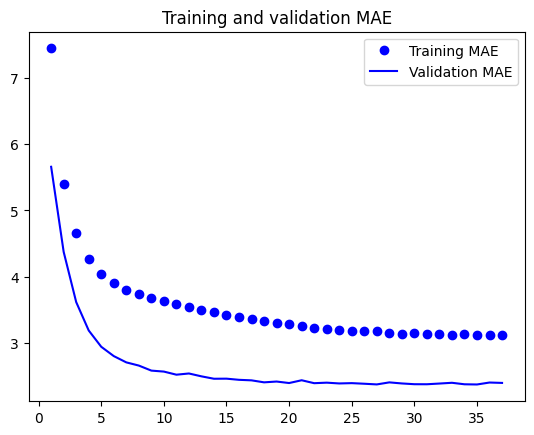

In [59]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked RNN using GRU:

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
stacked_rnn_gru_model = keras.Model(inputs, outputs)

stacked_rnn_gru_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 120, 8)            576       
                                                                 
 gru_1 (GRU)                 (None, 8)                 432       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1017 (3.97 KB)
Trainable params: 1017 (3.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
stacked_rnn_gru_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = stacked_rnn_gru_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping],
)
print(f"Test MAE: {stacked_rnn_gru_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50


2023-12-05 19:16:28.985712: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f241a13f860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 19:16:28.985727: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-05 19:16:28.988965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 19:16:29.280354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1701814589.316111   43120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


410/410 [==============================] - 59s 136ms/step - loss: 83.5410 - mae: 7.2026 - val_loss: 55.2804 - val_mae: 5.6517
Epoch 2/50
410/410 [==============================] - 56s 136ms/step - loss: 49.4319 - mae: 5.2674 - val_loss: 35.1718 - val_mae: 4.3617
Epoch 3/50
410/410 [==============================] - 56s 135ms/step - loss: 37.5395 - mae: 4.5481 - val_loss: 25.0079 - val_mae: 3.6392
Epoch 4/50
410/410 [==============================] - 56s 135ms/step - loss: 31.5591 - mae: 4.1719 - val_loss: 19.4717 - val_mae: 3.2180
Epoch 5/50
410/410 [==============================] - 56s 136ms/step - loss: 28.3597 - mae: 3.9699 - val_loss: 16.4315 - val_mae: 2.9847
Epoch 6/50
410/410 [==============================] - 56s 136ms/step - loss: 26.3016 - mae: 3.8401 - val_loss: 14.4289 - val_mae: 2.8266
Epoch 7/50
410/410 [==============================] - 56s 136ms/step - loss: 25.1641 - mae: 3.7592 - val_loss: 13.3212 - val_mae: 2.7498
Epoch 8/50
410/410 [==============================] 

In [16]:
stacked_rnn_gru_model.save('./models/stacked_rnn_gru_model.h5')

/home/alunos/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


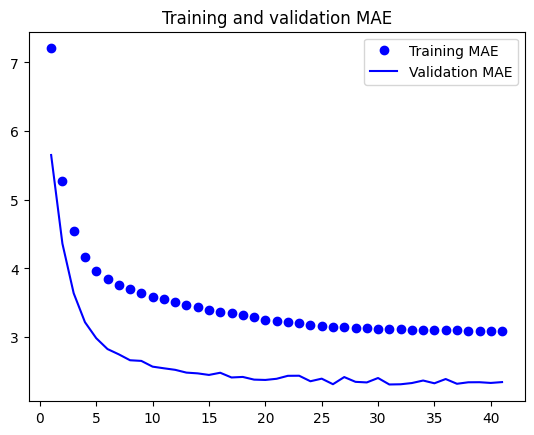

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Transformer

In [60]:
import keras
from keras import layers

def create_transformer_model(d_model=16, num_heads=2, dropout=1/3):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

    embedding_layer = layers.Embedding(sequence_length, d_model)
    embedding_indices = tf.range(sequence_length)
    embedding = embedding_layer(embedding_indices)
    x1 = layers.Dense(d_model)(inputs)
    x1 = x1 + embedding

    x2 = layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads, dropout=dropout)(x1, x1)
    x2 = layers.Conv1D(filters=d_model, kernel_size=1, activation="relu")(x2)
    x2 = layers.Dropout(dropout)(x2)
    x2 = layers.LayerNormalization()(x2)
    x2 = x2 + x1
    x2 = layers.GlobalAveragePooling1D()(x2)
    x2 = layers.Dense(8, activation="relu")(x2)

    temps = inputs[:, :, 1] * std[1] + mean[1]
    temps = layers.Reshape(temps.shape[1:] + (1,))(temps)

    naive_est = temps[:, -1, :]

    mean_est = inputs[:, :, :] * std[1] + mean[1]
    mean_est = layers.GlobalAveragePooling1D()(mean_est)
    mean_est = layers.Flatten()(mean_est)

    x3 = layers.Concatenate()([x2, naive_est, mean_est])
    x3 = layers.Dense(4, activation="relu")(x3)
    x3 = layers.Dropout(dropout)(x3)
    x3 = layers.LayerNormalization()(x3)
    x3 = layers.Concatenate()([x3, naive_est, mean_est])
    x3 = layers.Dense(1)(x3)

    outputs = x3

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

transformer_model = create_transformer_model()
transformer_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 120, 14)]            0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 120, 16)              240       ['input_13[0][0]']            
                                                                                                  
 tf.__operators__.add_12 (T  (None, 120, 16)              0         ['dense_12[0][0]']            
 FOpLambda)                                                                                       
                                                                                                  
 multi_head_attention (Mult  (None, 120, 16)              2160      ['tf.__operators__.add_

In [61]:
transformer_model.compile(optimizer='adam', loss="mse", metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

with tf.device("GPU:0"):
    transformer_history = transformer_model.fit(
        train_dataset,
        epochs=25,
        validation_data=val_dataset,
        callbacks=[early_stopping],
    )

print(f"Test MAE: {transformer_model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
410/410 [==============================] - 8s 14ms/step - loss: 54.3900 - mae: 5.6642 - val_loss: 25.9983 - val_mae: 4.0067
Epoch 2/25
410/410 [==============================] - 5s 13ms/step - loss: 23.4260 - mae: 3.8458 - val_loss: 16.8277 - val_mae: 3.2369
Epoch 3/25
410/410 [==============================] - 5s 13ms/step - loss: 17.2729 - mae: 3.3081 - val_loss: 13.5974 - val_mae: 2.9205
Epoch 4/25
410/410 [==============================] - 5s 13ms/step - loss: 14.5883 - mae: 3.0413 - val_loss: 12.1327 - val_mae: 2.7493
Epoch 5/25
410/410 [==============================] - 5s 13ms/step - loss: 13.2432 - mae: 2.8911 - val_loss: 11.2287 - val_mae: 2.6416
Epoch 6/25
410/410 [==============================] - 5s 13ms/step - loss: 12.4090 - mae: 2.7961 - val_loss: 10.5675 - val_mae: 2.5475
Epoch 7/25
410/410 [==============================] - 5s 13ms/step - loss: 11.8720 - mae: 2.7288 - val_loss: 10.1589 - val_mae: 2.4957
Epoch 8/25
410/410 [==============================] - 5

In [62]:
transformer_model.save('./models/transformer_model.h5')

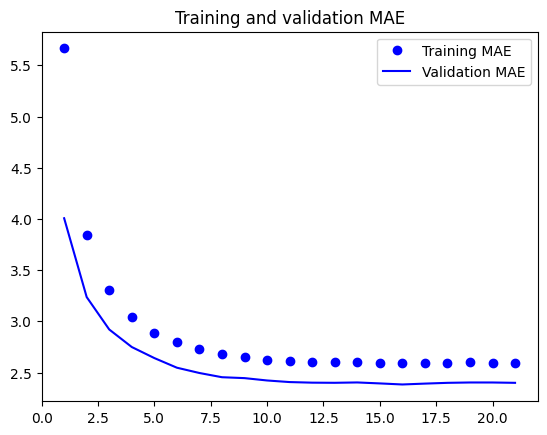

In [63]:
import matplotlib.pyplot as plt

loss = transformer_history.history["mae"]
val_loss = transformer_history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()